In [ ]:
import numpy as np 
import pandas as pd
import praw #for reddit wrapper
import matplotlib.pyplot as plt #for basic visualizations
import networkx as nx #to create Network Graphs

In [ ]:
reddit = praw.Reddit(client_id='#',
                     client_secret='#',
                     user_agent='#')

In [ ]:
def get_posts(subred_name, n):
    subreddit = reddit.subreddit(subred_name)
    posts_info = [] 
    
    for subm in subreddit.top(limit=n):
        
        subred_info = []
        subred_info.append(subm.id)  
        subred_info.append(str(subm.author)) 
        subred_info.append(subm.score)  
        subred_info.append(subm.upvote_ratio)
        subred_info.append(subm.num_comments)
        subred_info.append(subm.subreddit)
        posts_info.append(subred_info)
    
    sorted_info = sorted(posts_info, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(sorted_info, columns = ['id','author', 'score','upvote_ratio' ,'num_comments', 'subreddit'])
    return posts_df

In [ ]:
prog_df = get_posts('wallstreetbets', 250)
prog_df.head()

,id,author,score,upvote_ratio,num_comments,subreddit
0,l6j4r9,zjz,120763,0.92,27828,wallstreetbets
1,lgp6c6,zemora,93352,0.90,1869,wallstreetbets
2,l6e0kt,zakaria20199,103655,0.97,3653,wallstreetbets
3,l6z1yp,yellow_duck12,120652,0.97,1061,wallstreetbets
4,lswef6,xXxNOBELxXx,84532,0.88,2929,wallstreetbets


In [ ]:
freq_authors = prog_df[prog_df.duplicated(['author'], keep = False)]

In [ ]:
freq_authors = freq_authors[freq_authors.author != 'None']

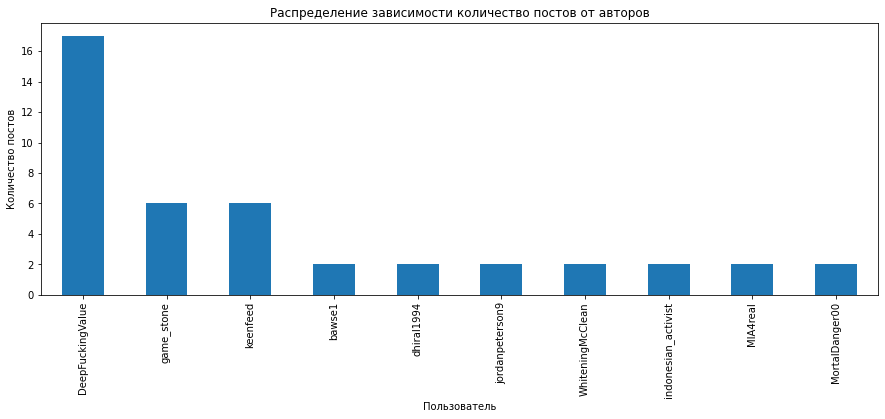

In [ ]:
plt.figure(figsize=(15, 5))
ax = freq_authors['author'].value_counts().plot(kind='bar',title='Распределение зависимости количество постов от авторов')
ax.set_xlabel("Пользователь")
ax.set_ylabel("Количество постов")
plt.savefig("posts_per_users_250.png")

In [ ]:
authors_lst = list(freq_authors.author.unique())

In [ ]:
from prawcore.exceptions import Forbidden

In [ ]:
authors_df =  pd.DataFrame() 
authors_df = authors_df.fillna(0)

for u in authors_lst: 
    try:
        user = reddit.redditor(u)
        submissions = user.submissions.new(limit=10)
        subm = [i for i in submissions]
        c = pd.DataFrame({'id': [i.id for i in subm],
                         'score': [i.score for i in subm],
                          'author': [i.author.name for i in subm],
                          'num_comments': [i.num_comments for i in subm],
                          'subreddit': [i.subreddit.display_name for i in subm]
                         })
    except Forbidden:
        pass
    
    authors_df = pd.concat([authors_df, c])

In [ ]:
authors_df

,id,score,author,num_comments,subreddit
0,l890i7,195376,keenfeed,4614,wallstreetbets
1,l881ia,232059,keenfeed,4658,wallstreetbets
2,l7sjdx,119735,keenfeed,1124,wallstreetbets
3,lavzb9,56934,keenfeed,1256,wallstreetbets
4,rk30we,2203,keenfeed,325,BMW
...,...,...,...,...,...
5,m0q5bm,167443,DeepFuckingValue,8207,wallstreetbets
6,lt7v4w,146964,DeepFuckingValue,7826,wallstreetbets
7,lnqgz8,218893,DeepFuckingValue,13108,wallstreetbets
8,lbykxg,144261,DeepFuckingValue,10148,wallstreetbets


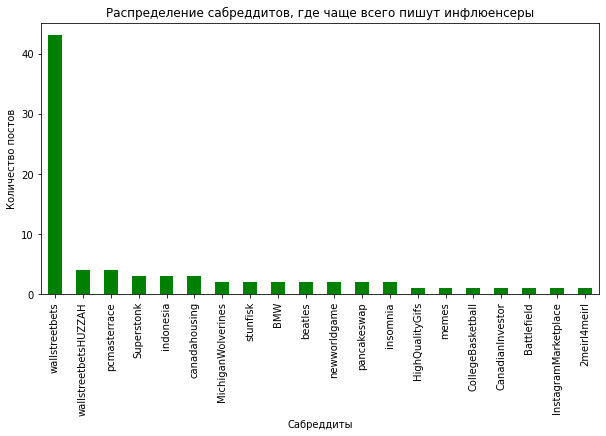

In [ ]:
plt.figure(figsize=(10, 5))
ax = authors_df['subreddit'].value_counts()[:20].plot(color='green', kind='bar',title='Распределение сабреддитов, где чаще всего пишут инфлюенсеры')
ax.set_xlabel("Сабреддиты")
ax.set_ylabel("Количество постов")
plt.savefig("posts_per_subreddits_250.png")

In [ ]:
nx_df = authors_df[['author', 'subreddit']]
nx_df

,author,subreddit
0,keenfeed,wallstreetbets
1,keenfeed,wallstreetbets
2,keenfeed,wallstreetbets
3,keenfeed,wallstreetbets
4,keenfeed,BMW
...,...,...
5,DeepFuckingValue,wallstreetbets
6,DeepFuckingValue,wallstreetbets
7,DeepFuckingValue,wallstreetbets
8,DeepFuckingValue,wallstreetbets


In [ ]:
g = nx.from_pandas_edgelist(nx_df, source='author', target='subreddit')

In [ ]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 49
Number of edges: 45
Average degree:   1.8367


In [ ]:
g.degree['wallstreetbets']

7

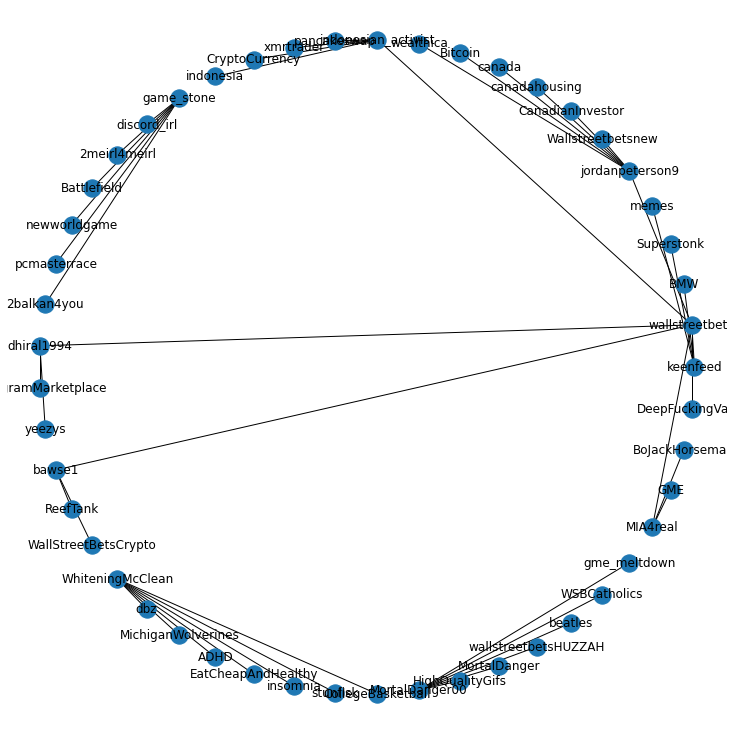

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 10))
d = dict(g.degree)
nx.draw_shell(g, with_labels=True)
plt.savefig("250_sub_net")

In [ ]:
leaderboard = {}
for x in g.nodes:
    leaderboard[x] = len(g[x])
s = pd.Series(leaderboard, name='connections')
df_conn = s.to_frame().sort_values('connections', ascending=False)

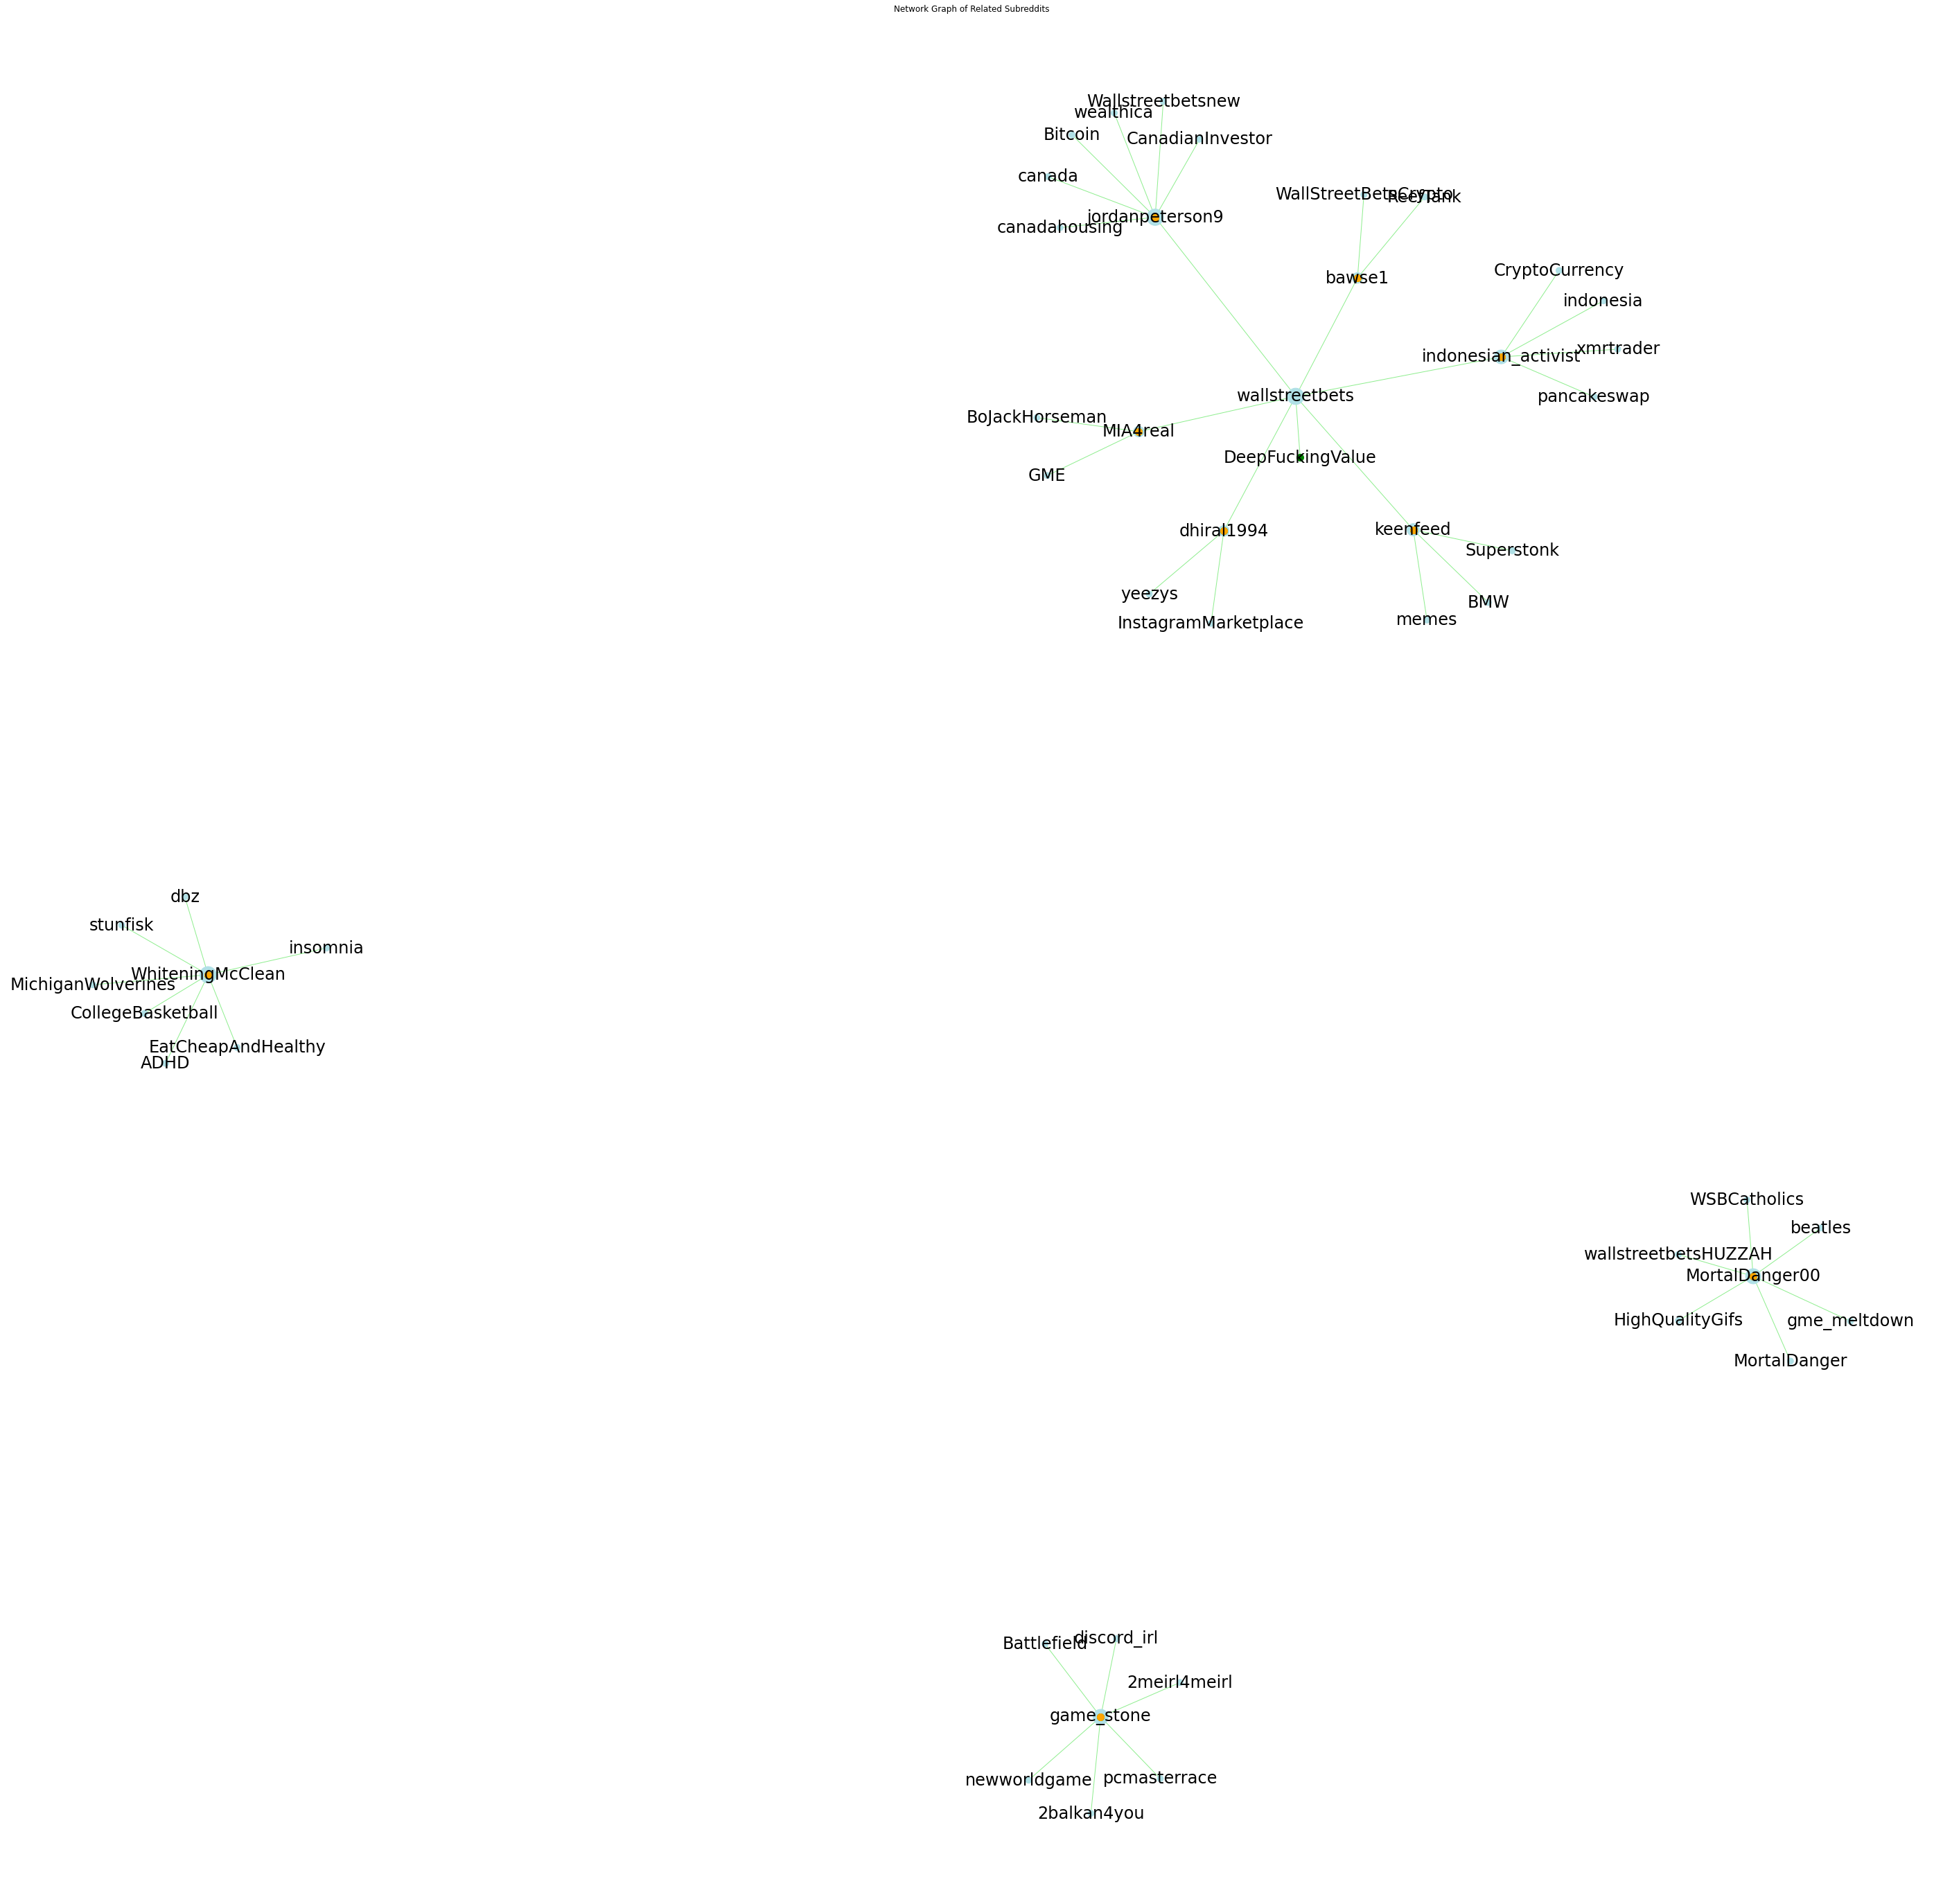

In [ ]:

# Create the graph from the dataframe [5]
plt.figure(figsize=(50,50))
g = nx.from_pandas_edgelist(nx_df, source='author', target='subreddit')
subs = list(g.nodes)
# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2) #//https://towardsdatascience.com/an-intro-to-graph-theory-centrality-measurements-and-networkx-1c2e580adf37

sub_size = [g.degree(sub) * 80 for sub in subs] #multiplying by 80 to get circular size
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, 
                       node_color='powderblue')

# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=authors_lst, node_color='green', node_size=100)
# Draw highly connected influencers 
popular_people = [person for person in authors_lst if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)
nx.draw_networkx_edges(g, layout, width=1, edge_color="lightgreen")
node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels, node_size=100,font_size=24)


plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig('graph_250.png')
plt.show()